# Metrics-Based Evaluation for Hybrid Mistral Model
## Evaluating results_hybrid_mistral.csv

In [1]:
# Install required packages (uncomment if needed)
# !pip install bert-score
# !pip install rouge
# !pip install nltk

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import argparse
import json
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge import Rouge
import numpy as np
import statistics
import pandas as pd
import bert_score

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score

import torch
from transformers import BertTokenizer, BertForMaskedLM

In [4]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [5]:
def read_result_csv(file_path):
    result_df = pd.read_csv(file_path)
    result_df.drop(result_df.columns[0], axis=1, inplace=True)
    return result_df

In [6]:
def compute_bleu(reference, candidate):
    reference = [[ref.split()] for ref in reference]
    candidate = [cand.split() for cand in candidate]
    smoothing_function = SmoothingFunction().method4
    bleu_scores = [corpus_bleu([ref], [cand], smoothing_function=smoothing_function) for ref, cand in zip(reference, candidate)]
    mean_bleu_score = np.mean(bleu_scores)
    bleu_std_dev = np.std(bleu_scores)
    return round(mean_bleu_score, 3), round(bleu_std_dev, 3)

In [7]:
def compute_bleu_unigram(reference, candidate):
    reference = [[ref.split()] for ref in reference]
    candidate = [cand.split() for cand in candidate]
    smoothing_function = SmoothingFunction().method4
    weights = (1, 0, 0, 0)
    bleu_scores = [corpus_bleu([ref], [cand], smoothing_function=smoothing_function, weights=weights) for ref, cand in zip(reference, candidate)]
    mean_bleu_score = round(np.mean(bleu_scores), 3)
    bleu_std_dev = round(np.std(bleu_scores), 3)
    return mean_bleu_score, bleu_std_dev

In [8]:
def compute_rouge(reference, candidate):
    rouge = Rouge()
    rouge_scores = [rouge.get_scores(cand, ref, avg=True) for ref, cand in zip(reference, candidate)]
    
    rouge_1_f_scores = [score['rouge-1']['f'] for score in rouge_scores]
    rouge_2_f_scores = [score['rouge-2']['f'] for score in rouge_scores]
    rouge_l_f_scores = [score['rouge-l']['f'] for score in rouge_scores]

    mean_rouge_1_f_score = np.mean(rouge_1_f_scores)
    mean_rouge_2_f_score = np.mean(rouge_2_f_scores)
    mean_rouge_l_f_score = np.mean(rouge_l_f_scores)

    rouge_1_f_std_dev = np.std(rouge_1_f_scores)
    rouge_2_f_std_dev = np.std(rouge_2_f_scores)
    rouge_l_f_std_dev = np.std(rouge_l_f_scores)

    return (
        round(mean_rouge_1_f_score, 3), round(rouge_1_f_std_dev, 3),
        round(mean_rouge_2_f_score, 3), round(rouge_2_f_std_dev, 3),
        round(mean_rouge_l_f_score, 3), round(rouge_l_f_std_dev, 3)
    )

In [9]:
def compute_bert_score(reference, candidate):
    bert_p_scores, bert_r_scores, bert_f1_scores = bert_score.score(candidate, reference, lang="en", verbose=False)
    return round(bert_f1_scores.mean().item(), 3), round(bert_f1_scores.std().item(), 3)

In [10]:
def compute_meteor_scores(reference, candidate):
    tokenized_candidates = [word_tokenize(cand.replace("<s>", "").replace("</s>", "").strip()) for cand in candidate]
    tokenized_references = [word_tokenize(sentence) for sentence in reference]
    meteor_scores = []
    for ref_sentence, candidate_tokens in zip(tokenized_references, tokenized_candidates):
        meteor_scores.append(single_meteor_score(ref_sentence, candidate_tokens))
    meteor_scores_mean = sum(meteor_scores) / len(meteor_scores)
    meteor_scores_std = statistics.stdev(meteor_scores)
    return round(meteor_scores_mean, 3), round(meteor_scores_std, 3)

In [11]:
import re
from nltk.tokenize import sent_tokenize

def clean_text(text):
    regex = r"[^a-zA-Z0-9.,!?;:'\"()\[\]{}\-\s]"
    cleaned_text = re.sub(regex, '', text)
    lines = sent_tokenize(cleaned_text)
    
    seen = set()
    unique_lines = []
    for line in lines:
        cleaned_line = re.sub(r'\s+', ' ', line).strip()
        if cleaned_line not in seen:
            seen.add(cleaned_line)
            unique_lines.append(cleaned_line)
    
    unique_lines = unique_lines[:2]
    return ' '.join(unique_lines)

In [12]:
def cleanup_pred_captions(predicted_captions):
    cleaned_captions = []
    for caption in predicted_captions:
        cleaned_caption = clean_text(str(caption))
        cleaned_captions.append(cleaned_caption)
    return cleaned_captions

In [13]:
def run(csv_path):
    results = {}
    result_df = read_result_csv(csv_path)

    image_paths = result_df['Ground Truth Image']
    expected_captions = result_df['Expected Caption']
    predicted_captions = result_df['Generated Caption']
    expected_object_classes = result_df['Expected object']
    predicted_object_classes = result_df['Predicted object']

    predicted_captions = cleanup_pred_captions(predicted_captions)
    references = expected_captions.tolist()
    candidates = predicted_captions

    for i, cand in enumerate(candidates):
        if len(cand) <= 1:
            candidates[i] = "No response"

    # BLEU Score
    mean_bleu_score, bleu_std_dev = compute_bleu(references, candidates)
    results["Mean BLEU Score"] = mean_bleu_score
    results["SD BLEU Score"] = bleu_std_dev

    # BLEU Unigram
    mean_bleu_unigram, bleu_unigram_std = compute_bleu_unigram(references, candidates)
    results["Mean BLEU-1"] = mean_bleu_unigram
    results["SD BLEU-1"] = bleu_unigram_std

    # ROUGE Scores
    rouge_1_mean, rouge_1_std, rouge_2_mean, rouge_2_std, rouge_l_mean, rouge_l_std = compute_rouge(references, candidates)
    results["Mean ROUGE-1"] = rouge_1_mean
    results["SD ROUGE-1"] = rouge_1_std
    results["Mean ROUGE-2"] = rouge_2_mean
    results["SD ROUGE-2"] = rouge_2_std
    results["Mean ROUGE-L"] = rouge_l_mean
    results["SD ROUGE-L"] = rouge_l_std

    # METEOR Score
    meteor_mean, meteor_std = compute_meteor_scores(references, candidates)
    results["Mean METEOR"] = meteor_mean
    results["SD METEOR"] = meteor_std

    # BERTScore
    bert_mean, bert_std = compute_bert_score(references, candidates)
    results["Mean BERTScore"] = bert_mean
    results["SD BERTScore"] = bert_std

    # Object Classification Accuracy
    accuracy = accuracy_score(expected_object_classes, predicted_object_classes)
    results["Object Classification Accuracy"] = round(accuracy, 3)

    return results

## Evaluate Your Results
### Single File Evaluation

In [14]:
# Evaluate your hybrid mistral results
csv_path = "results_hybrid_mistral.csv"
results = run(csv_path)

# Display results
print("="*60)
print("Evaluation Results for Hybrid Mistral Model")
print("="*60)
for metric, value in results.items():
    print(f"{metric:.<40} {value}")
print("="*60)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Results for Hybrid Mistral Model
Mean BLEU Score......................... 0.058
SD BLEU Score........................... 0.082
Mean BLEU-1............................. 0.26
SD BLEU-1............................... 0.151
Mean ROUGE-1............................ 0.309
SD ROUGE-1.............................. 0.152
Mean ROUGE-2............................ 0.086
SD ROUGE-2.............................. 0.118
Mean ROUGE-L............................ 0.28
SD ROUGE-L.............................. 0.144
Mean METEOR............................. 0.258
SD METEOR............................... 0.158
Mean BERTScore.......................... 0.894
SD BERTScore............................ 0.027
Object Classification Accuracy.......... 0.581


### Convert to DataFrame

In [15]:
# Create a nice DataFrame for the results
results_df = pd.DataFrame([results])
results_df = results_df.T  # Transpose for better readability
results_df.columns = ['Hybrid Mistral']
print(results_df)

                                Hybrid Mistral
Mean BLEU Score                          0.058
SD BLEU Score                            0.082
Mean BLEU-1                              0.260
SD BLEU-1                                0.151
Mean ROUGE-1                             0.309
SD ROUGE-1                               0.152
Mean ROUGE-2                             0.086
SD ROUGE-2                               0.118
Mean ROUGE-L                             0.280
SD ROUGE-L                               0.144
Mean METEOR                              0.258
SD METEOR                                0.158
Mean BERTScore                           0.894
SD BERTScore                             0.027
Object Classification Accuracy           0.581


### Save Results

In [16]:
# Save to CSV
results_df.to_csv("hybrid_mistral_evaluation_results.csv")
print("Results saved to: hybrid_mistral_evaluation_results.csv")

Results saved to: hybrid_mistral_evaluation_results.csv


## Visualize Results

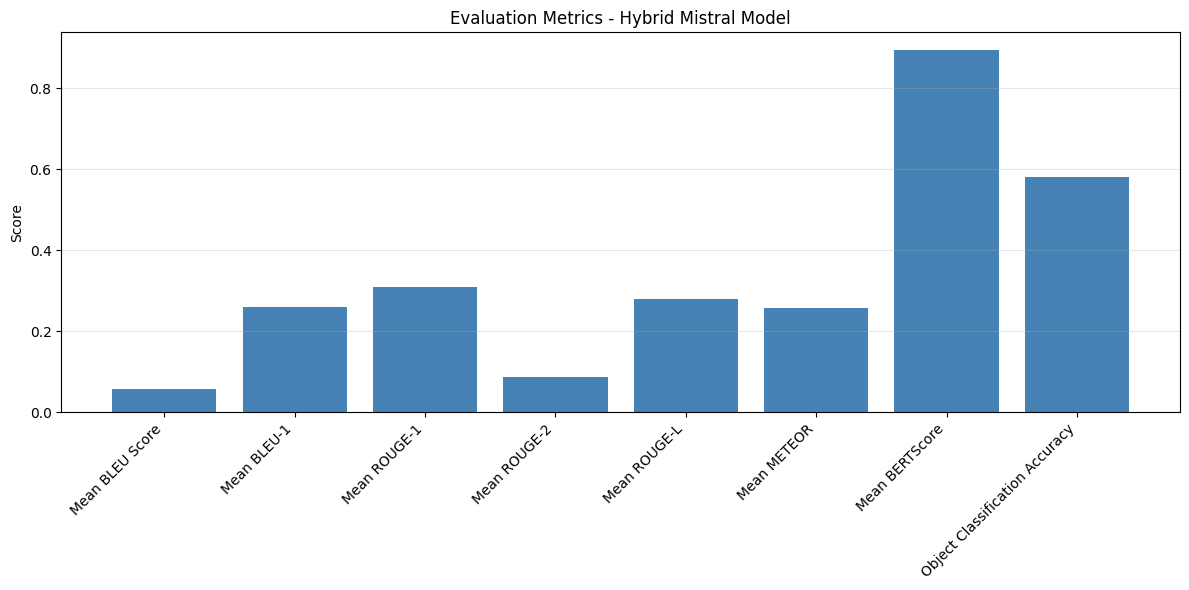

Visualization saved to: hybrid_mistral_metrics.png


In [18]:
# Create a bar plot of the metrics
metrics_to_plot = [k for k in results.keys() if 'Mean' in k or 'Accuracy' in k]
values_to_plot = [results[k] for k in metrics_to_plot]

plt.figure(figsize=(12, 6))
plt.bar(range(len(metrics_to_plot)), values_to_plot, color='steelblue')
plt.xticks(range(len(metrics_to_plot)), metrics_to_plot, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Evaluation Metrics - Hybrid Mistral Model')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.savefig('hybrid_mistral_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualization saved to: hybrid_mistral_metrics.png")